# Task 1: Data Integration and Ontology Definition

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

### 1. Load Datasets
Load all required datasets into the notebook for analysis.  
- `Orders.csv` → contains order information  
- `Inventory.csv` → contains current stock levels  
- `Shipments.csv` → contains shipment details

In [21]:
orders = pd.read_csv("Orders.csv")
inventory = pd.read_csv("Inventory.csv")
shipments = pd.read_csv("Shipments.csv")

In [22]:
print("Orders rows:", orders.shape[0])
print("Inventory rows:", inventory.shape[0])
print("Shipments rows:", shipments.shape[0])

Orders rows: 100
Inventory rows: 57
Shipments rows: 80


###  2. Order Data Cleaning & Validation
This step ensures the `orders` dataset is clean, consistent, and ready for analysis.  

**Tasks performed:**
1. **Enforce Data Types** – ensure IDs are strings, dates are proper datetime objects, and status strings are stripped.
2. **Check for Null / Missing Values** – identify missing data per column.
3. **Apply Constraints** – check for duplicates, invalid order statuses, and future order dates.
4. **Summary Reports** – display issues found.
5. **Clean Up Invalid Values** – drop duplicates, correct invalid statuses, and remove future/missing dates.


In [23]:
# --- 1️⃣ Enforce Data Types ---
orders['order_id'] = orders['order_id'].astype(str)       # unique identifier
orders['customer_id'] = orders['customer_id'].astype(str) # unique identifier
orders['product_id'] = orders['product_id'].astype(str)   # product reference
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce') # enforce datetime
orders['order_status'] = orders['order_status'].astype(str).str.strip()      # cleanup strings

# --- 2️⃣ Check for Null / Missing Values ---
print("Null values per column:")
print(orders.isnull().sum())

# --- 3️⃣ Apply Constraints ---
# Constraint 1: order_id must be unique
duplicate_orders = orders[orders.duplicated(subset=['order_id'], keep=False)]

# Constraint 2: order_status must be valid
allowed_status = {"Pending", "Shipped", "Delivered", "Canceled"}
invalid_status = orders[~orders['order_status'].isin(allowed_status)]

# Constraint 3: order_date should not be in the future
future_orders = orders[orders['order_date'] > pd.Timestamp.now()]

# --- 4️⃣ Summary Reports ---
print("\n🚨 Duplicate Orders Found:")
print(duplicate_orders if not duplicate_orders.empty else "✅ None")

print("\n🚨 Invalid Order Statuses:")
print(invalid_status if not invalid_status.empty else "✅ None")

print("\n🚨 Orders with Future Dates:")
print(future_orders if not future_orders.empty else "✅ None")

# --- 5️⃣ Clean up invalid values (Optional step) ---
# Drop duplicates (keeping first occurrence)
orders = orders.drop_duplicates(subset=['order_id'], keep='first')

# Replace invalid statuses with 'Pending' (or drop them)
orders.loc[~orders['order_status'].isin(allowed_status), 'order_status'] = 'Unknown'

# Drop rows where order_date is missing or in the future
orders = orders.dropna(subset=['order_date'])
orders = orders[orders['order_date'] <= pd.Timestamp.now()]

print("\n✅ Orders table cleaned and validated!")



Null values per column:
order_id        0
customer_id     0
product_id      0
order_date      0
order_status    0
dtype: int64

🚨 Duplicate Orders Found:
✅ None

🚨 Invalid Order Statuses:
✅ None

🚨 Orders with Future Dates:
✅ None

✅ Orders table cleaned and validated!


In [32]:
orders.head()

,order_id,customer_id,product_id,order_date,order_status
0,O0001,C007,P008,2025-02-26,Delivered
1,O0002,C020,P014,2025-02-01,Delivered
2,O0003,C029,P008,2025-02-23,Delivered
3,O0004,C015,P016,2025-04-21,Delivered
4,O0005,C011,P013,2025-04-21,Delivered


###  3. Inventory Data Cleaning & Validation
Ensure the `inventory` dataset is accurate and ready for analysis.

**Tasks performed:**
1. **Enforce Data Types** – convert IDs to strings and stock quantity to numeric.
2. **Check for Null / Missing Values** – identify missing data per column.
3. **Apply Constraints** – ensure stock quantities are non-negative, unique per product-warehouse combination, and integers.
4. **Summary Reports** – display invalid or duplicate records.
5. **Clean Up Invalid Values (Optional)** – correct negative stocks, remove duplicates, and convert stock quantities to integers.


In [33]:
# --- 1️⃣ Enforce Data Types ---
inventory['product_id'] = inventory['product_id'].astype(str)      # product reference
inventory['warehouse_id'] = inventory['warehouse_id'].astype(str)  # warehouse reference
inventory['stock_quantity'] = pd.to_numeric(inventory['stock_quantity'], errors='coerce') # must be integer

# --- 2️⃣ Check for Null / Missing Values ---
print("Null values per column:")
print(inventory.isnull().sum())

# --- 3️⃣ Apply Constraints ---
# Constraint 1: stock_quantity must be >= 0
invalid_stock = inventory[inventory['stock_quantity'] < 0]

# Constraint 2: product_id + warehouse_id should be unique (no duplicate rows)
duplicate_inventory = inventory[inventory.duplicated(subset=['product_id', 'warehouse_id'], keep=False)]

# Constraint 3: stock_quantity should be integer (not float)
non_integer_stock = inventory[inventory['stock_quantity'] % 1 != 0]

# --- 4️⃣ Summary Reports ---
print("\n🚨 Invalid Stock (Negative Values):")
print(invalid_stock if not invalid_stock.empty else "✅ None")

print("\n🚨 Duplicate Product-Warehouse Records:")
print(duplicate_inventory if not duplicate_inventory.empty else "✅ None")

print("\n🚨 Non-integer Stock Quantities:")
print(non_integer_stock if not non_integer_stock.empty else "✅ None")

# --- 5️⃣ Clean up invalid values (Optional step) ---
# Replace negative stock with 0
inventory.loc[inventory['stock_quantity'] < 0, 'stock_quantity'] = 0

# Drop duplicate product-warehouse combinations, keep first
inventory = inventory.drop_duplicates(subset=['product_id', 'warehouse_id'], keep='first')

# Convert float stock quantities to integer
inventory['stock_quantity'] = inventory['stock_quantity'].fillna(0).astype(int)

print("\n✅ Inventory table cleaned and validated!")


Null values per column:
product_id        0
warehouse_id      0
stock_quantity    0
dtype: int64

🚨 Invalid Stock (Negative Values):
✅ None

🚨 Duplicate Product-Warehouse Records:
✅ None

🚨 Non-integer Stock Quantities:
✅ None

✅ Inventory table cleaned and validated!


In [34]:
inventory.head()

,product_id,warehouse_id,stock_quantity
0,P001,W01,95
1,P001,W02,47
2,P001,W03,88
3,P002,W01,0
4,P002,W02,15


###  4. Shipments Data Cleaning & Validation
Ensure the `shipments` dataset is accurate and ready for analysis.

**Tasks performed:**
1. **Enforce Data Types** – convert IDs and strings to proper types and clean whitespace.
2. **Check for Null / Missing Values** – identify missing data per column.
3. **Apply Constraints** – ensure unique shipment IDs, valid statuses, and non-empty carriers.
4. **Summary Reports** – display duplicates, invalid statuses, and missing carriers.
5. **Clean Up Invalid Values (Optional)** – drop duplicates, replace invalid statuses, and fill missing carriers.


In [27]:
# --- 1️⃣ Enforce Data Types ---
shipments['shipment_id'] = shipments['shipment_id'].astype(str)  # unique identifier
shipments['order_id'] = shipments['order_id'].astype(str)        # foreign key to Orders
shipments['carrier'] = shipments['carrier'].astype(str).str.strip()  # clean strings
shipments['status'] = shipments['status'].astype(str).str.strip()    # clean strings

# --- 2️⃣ Check for Null / Missing Values ---
print("Null values per column:")
print(shipments.isnull().sum())

# --- 3️⃣ Apply Constraints ---
# Constraint 1: shipment_id must be unique
duplicate_shipments = shipments[shipments.duplicated(subset=['shipment_id'], keep=False)]

# Constraint 2: status must be one of allowed values
allowed_status = {"In Transit", "Delivered", "Delayed"}
invalid_status = shipments[~shipments['status'].isin(allowed_status)]

# Constraint 3: carrier should not be empty
invalid_carrier = shipments[shipments['carrier'].str.strip() == ""]

# --- 4️⃣ Summary Reports ---
print("\n🚨 Duplicate Shipments Found:")
print(duplicate_shipments if not duplicate_shipments.empty else "✅ None")

print("\n🚨 Invalid Shipment Statuses:")
print(invalid_status if not invalid_status.empty else "✅ None")

print("\n🚨 Missing/Empty Carrier Names:")
print(invalid_carrier if not invalid_carrier.empty else "✅ None")

# --- 5️⃣ Clean up invalid values (Optional step) ---
# Drop duplicate shipments (keeping first occurrence)
shipments = shipments.drop_duplicates(subset=['shipment_id'], keep='first')

# Replace invalid statuses with 'In Transit' (or another default)
shipments.loc[~shipments['status'].isin(allowed_status), 'status'] = 'Unknown'

# Replace missing/empty carrier with 'Unknown'
shipments['carrier'] = shipments['carrier'].replace("", "Unknown")

print("\n✅ Shipments table cleaned and validated!")


Null values per column:
shipment_id    0
order_id       0
carrier        0
status         0
dtype: int64

🚨 Duplicate Shipments Found:
✅ None

🚨 Invalid Shipment Statuses:
✅ None

🚨 Missing/Empty Carrier Names:
✅ None

✅ Shipments table cleaned and validated!


In [35]:
shipments.head()

,shipment_id,order_id,carrier,status
0,S0001,O0001,CarrierA,Delivered
1,S0002,O0027,CarrierB,Delivered
2,S0003,O0076,CarrierB,Delivered
3,S0004,O0078,CarrierB,Delivered
4,S0005,O0006,CarrierB,Delivered


### 5. Orders & Shipments Analysis
Analyze the relationship between orders and shipments to identify missing shipments and status mismatches.

**Tasks performed:**
1. Merge `orders` and `shipments` datasets on `order_id`.
2. Count orders that have no corresponding shipment.
3. Compare `order_status` with `shipment status` to identify matches and mismatches.
4. Summarize and visualize the results using a bar chart.

**Note:** This analysis helps highlight discrepancies in the data:
- Orders without shipments indicate missing or delayed records.
- Mismatches between `order_status` and `shipment status` show inconsistencies in how order progress was recorded across datasets.



In [29]:
orders_shipments = pd.merge(orders, shipments, on='order_id', how='left')


In [36]:
orders_shipments.head()

,order_id,customer_id,product_id,order_date,order_status,shipment_id,carrier,status,match_status
0,O0001,C007,P008,2025-02-26,Delivered,S0001,CarrierA,Delivered,Match
1,O0002,C020,P014,2025-02-01,Delivered,S0078,CarrierA,Delayed,Mismatch
2,O0003,C029,P008,2025-02-23,Delivered,S0021,CarrierB,Delivered,Match
3,O0004,C015,P016,2025-04-21,Delivered,S0019,CarrierC,Delivered,Match
4,O0005,C011,P013,2025-04-21,Delivered,S0022,CarrierC,Delivered,Match


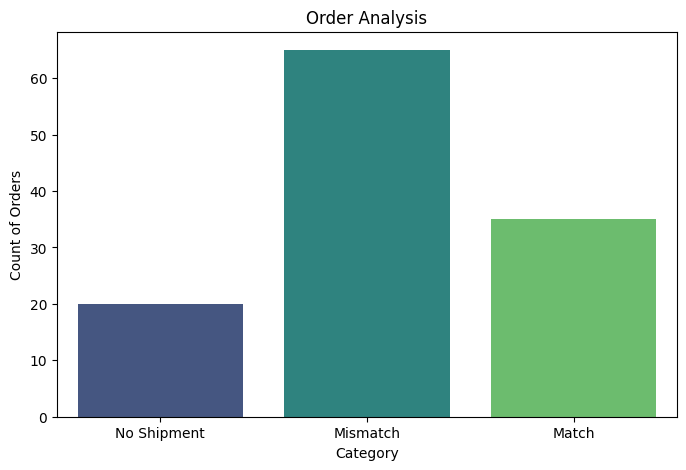

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count of orders without shipment_id
no_shipment_count = orders_shipments['shipment_id'].isna().sum()

# 2. Count of order_status and status match/mismatch
# Handle missing values in 'status' by treating them as a mismatch
orders_shipments['match_status'] = orders_shipments.apply(lambda x: 'Match' if x['order_status']==x['status'] else 'Mismatch', axis=1)
match_counts = orders_shipments['match_status'].value_counts()

# 3. Combine for plotting
summary = pd.DataFrame({
    'Category': ['No Shipment'] + match_counts.index.tolist(),
    'Count': [no_shipment_count] + match_counts.tolist()
})

# 4. Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Category', y='Count', hue='Category', data=summary, dodge=False, palette='viridis', legend=False)
plt.title("Order Analysis")
plt.ylabel("Count of Orders")
plt.show()



###  6. Merge with Inventory
Attempt to combine the merged `orders_shipments` dataset with `inventory` to get stock levels per product per warehouse.  

**Note:** This merge highlights a limitation in the current data gathering: because `orders_shipments` can have multiple rows per product and `inventory` can have multiple rows per product per warehouse, merging on `product_id` creates duplicate rows.  
This shows that with the current datasets, we **cannot directly determine whether orders can be fulfilled** without additional logic to handle many-to-many relationships.


In [19]:
# Merge with Inventory to know stock per product per warehouse
full_data = pd.merge(orders_shipments, inventory, on='product_id', how='left')

full_data.head()


,order_id,customer_id,product_id,order_date,order_status,shipment_id,carrier,status,match_status,warehouse_id,stock_quantity
0,O0001,C007,P008,2025-02-26,Delivered,S0001,CarrierA,Delivered,Match,W01,68
1,O0001,C007,P008,2025-02-26,Delivered,S0001,CarrierA,Delivered,Match,W02,46
2,O0001,C007,P008,2025-02-26,Delivered,S0001,CarrierA,Delivered,Match,W03,93
3,O0002,C020,P014,2025-02-01,Delivered,S0078,CarrierA,Delayed,Mismatch,W01,99
4,O0002,C020,P014,2025-02-01,Delivered,S0078,CarrierA,Delayed,Mismatch,W02,33


###  7. Ontology Design to Prevent Data Issues

Based on the analyses above, the current datasets show several issues:
- Orders without shipments create gaps in tracking.
- Mismatches between `order_status` and `shipment status` reveal inconsistencies.
- Merging with inventory can create duplicate rows due to many-to-many relationships.

To address these issues, I designed an **ontology model** that connects orders, inventory, and shipments, ensuring:

1. **Orders linked to Shipments**  
   Every order is associated with one or more shipments, making it easier to track fulfillment and detect missing shipments.

2. **Products associated with Warehouse Inventory**  
   Products are clearly mapped to specific warehouse stock, preventing duplication and allowing accurate allocation.

3. **Customers’ Order Histories Trackable**  
   Each customer’s past orders are connected, enabling better insights and analytics.

4. **Clear Definitions for Every Data Attribute**  
   Each field (e.g., `order_status`, `shipment status`, `stock_quantity`) has a standardized definition, preventing inconsistencies.

5. **Defined Constraints for Data Integrity**  
   Constraints are applied at the ontology level to ensure uniqueness, valid statuses, non-negative stock, and proper date ranges.

**Outcome:**  
The ontology ensures that data discrepancies seen in the current datasets are prevented, enabling accurate tracking of orders, shipments, and inventory, and supporting reliable business insights.

![oa](oa.drawio.png)


